In [1]:
import numpy as np
import cv2 as cv
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import random
%matplotlib inline

### Q1

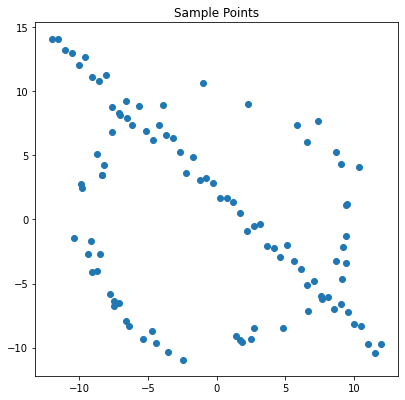

In [3]:
np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n , 1) ,y.reshape(half_n, 1 ) ) )
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

#plot figure
plt.figure(figsize=(6.5,6.5))
plt.plot(X_circ[:,0], X_circ[:,1], 'o', color="C0")
plt.plot(X_line[:,0], X_line[:,1], 'o', color="C0")
plt.title("Sample Points")
plt.show()

In [4]:
def getCircle(x, y, z):
    """Returns center coordinates and radius when given three points.
    Returns False if no circle can be fitted"""
    x = complex(x[0], x[1])
    y = complex(y[0], y[1])
    z = complex(z[0], z[1])
    try:
        w = (z-x)/(y-x)
        c = (x-y)*(w-abs(w)**2)/(2j*w.imag)-x
    except ZeroDivisionError:
        return False, False, False

    return (-c.real, -c.imag, abs(c+x))  # (center_x, center_y, r)


def calcError(f, g, r, inliers):
    Sum = 0
    for pt in inliers:
        Sum += abs(np.sqrt((pt[0]-f)**2 +
                   (pt[1]-g)**2) - r)
    error = Sum/len(inliers)
    return error


def bestFitCircle(inliers):
    """Function to best-fit a circle to a given inlier dataset. Returns Center coordinates and radius"""
    x, y = inliers[:, 0], inliers[:, 1]
    N = len(x)
    x_mu, y_mu = np.mean(x), np.mean(y)
    u, v = (x - x_mu), (y - y_mu)

    a11 = sum(u**2)
    a22 = sum(v**2)
    a12 = a21 = sum(u*v)
    b1 = 0.5*(sum(u*(u**2 + v**2)))
    b2 = 0.5*(sum(v*(u**2 + v**2)))

    A = np.array([[a11, a12], [a21, a22]])
    B = np.array([[b1], [b2]])
    u_c, v_c = np.linalg.inv(A) @ B

    f = u_c + x_mu
    g = v_c + y_mu

    r = np.sqrt(u_c**2 + v_c**2 + (sum(u**2 + v**2))/(N))

    return f, g, r


def getInlierCount(f, g, r, X, t):
    
    best_fit_inliers = None
    inlier_count = 0

    for i in range(X.shape[0]):
        distance = abs(((X[i, 0] - f)**2 + (X[i, 1] - g)**2) ** 0.5 - r)

        if distance < t:
            inlier_count += 1

            if type(best_fit_inliers) == type(None):
                best_fit_inliers = np.array([X[i, :]])
            else:
                best_fit_inliers = np.concatenate(
                    (best_fit_inliers, X[i, :].reshape(1, -1)), axis=0)

    return inlier_count, best_fit_inliers


In [5]:
def RANSAC_circ(X):

    e = 0.5     # outlier ratio
    s = 3       # Number of points needed to create the estimated model
    p = 0.99    # Probability to choose number of iteration cycles
    t = 1.96 * 10/16   # treshold distance to determine inliers and outliers
    d = 50      # expected number of inliers

    iter_rounds = int(np.ceil(np.log(1-p)/np.log(1-(1-e)**s)))

    best_inlier_count = 0
    best_samples = None
    best_fit_inliers = None

    for _ in range(iter_rounds):

        # choose 3 distinct points from dataset 
        [p1, p2, p3] = np.random.choice(len(X), size=3, replace=False)
        [p1, p2, p3] = X[p1, :], X[p2, :], X[p3, :]

        # get circle through the 3 points
        f, g, r = getCircle(p1, p2, p3)

        if r == None:
            continue

        inlier_count, inliers = getInlierCount(f, g, r, X, t)

        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_fit_inliers = inliers
            best_samples = [p1, p2, p3]
            best_fit_circle = [f, g, r]
            

    if best_inlier_count < d:
        # repeat ransac if no model found
        RANSAC_circ(X)

    ransac_circle = bestFitCircle(best_fit_inliers) #f,g,r

    return ransac_circle, best_fit_circle, best_samples, best_fit_inliers


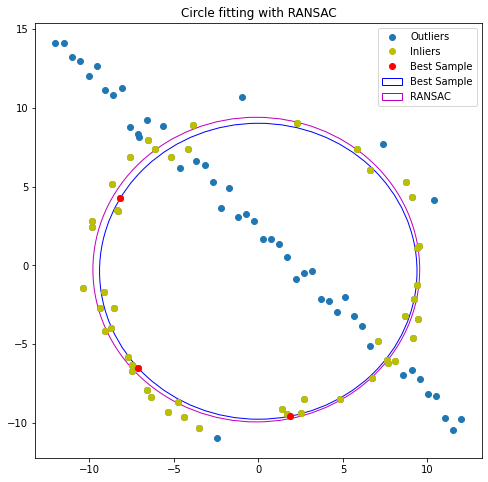

In [58]:
ransac_circle, best_fit_circle, best_samples, inliers = RANSAC_circ(X)


fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_circ[:,0], X_circ[:,1], color='C0')
ax.scatter(X_line[:,0], X_line[:,1], color='C0', label="Outliers")


for point in inliers:
    if np.array_equal(point, inliers[-1]):
        ax.plot(point[0], point[1], 'yo', label="Inliers")
    else:
        ax.plot(point[0], point[1], 'yo')


for point in best_samples:
    if np.array_equal(point, best_samples[-1]):
        ax.plot(point[0], point[1], 'ro', label="Best Sample")
    
    else:
        ax.plot(point[0], point[1], 'ro')

f,g,r = ransac_circle        
ransac_circle = plt.Circle((f,g), r, color='m', fill=False, label="RANSAC")
f,g,r = best_fit_circle
best_fit_circle = plt.Circle((f, g), r, color='b', fill=False, label="Best Sample")
ax.add_artist(best_fit_circle)
ax.add_artist(ransac_circle)
ax.set_title("Circle fitting with RANSAC")
ax.legend(loc="upper right")
plt.show()

### Q2

In [13]:
def click_event(event, x, y, flags, params):
    global points
    global click_count

        
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x, y])
        click_count += 1

        cv.circle(img, (x, y), 5, (0, 0, 255), -1)
        cv.imshow('Image', img)

    if click_count == 4:
        return


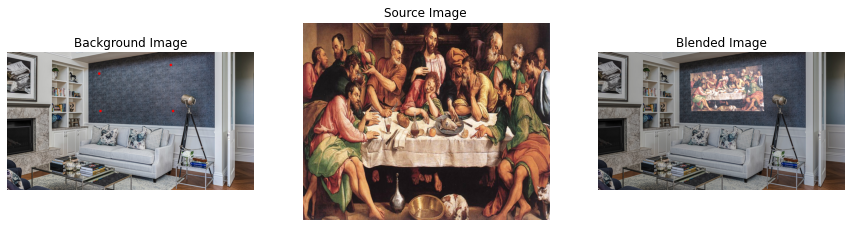

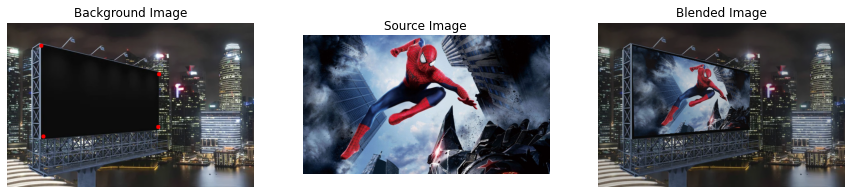

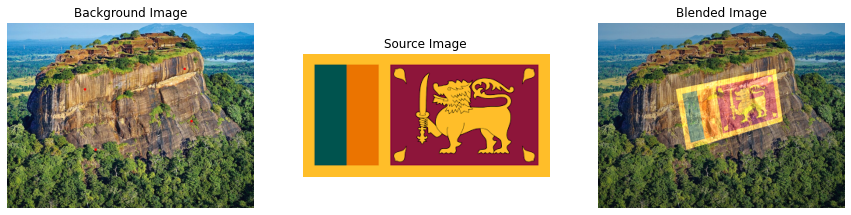

In [14]:

# flag and building 'Images/flag.jpeg','Images/Building/001.jpg',(1,0.6,0.2)
source_images = ['Images/painting.jpg',
                 'Images/spidey.jpg', 'Images/flag.png']

backgroung_images = ['Images/Wall.jpg', 'Images/billboard.jpg',
                     'Images/sigiriya.jpg']
                     
                     
coeff = [(0.8, 0.85, 0.3), (0.8, 0.8, 0.3), (0.8, 0.6, 0.3)]
images = []

for i in range(len(source_images)):
    points = []
    click_count = 0

    img = cv.imread(backgroung_images[i], 1)

    cv.imshow('Image', img)
    cv.setMouseCallback('Image', click_event)
    cv.waitKey(0)
    cv.destroyAllWindows()

    im_src = cv.imread(source_images[i])
    w, h = im_src.shape[1], im_src.shape[0]
    pts_src = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]])

    im_dst = cv.imread(backgroung_images[i])
    pts_dst = np.array(points)

    h, status = cv.findHomography(pts_src, pts_dst)
    im_out = cv.warpPerspective(im_src, h, (im_dst.shape[1], im_dst.shape[0]))
    blend = cv.addWeighted(im_dst, coeff[i][0], im_out, coeff[i][1], coeff[i][2])
    images.append([img, im_src, blend]) 

    cv.imshow("Blended Image", blend)
    cv.waitKey(0)
    cv.destroyAllWindows()

for im in images:
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    titles = ['Background Image', 'Source Image', 'Blended Image']
    
    for j in range(3):
        transformed_img = cv.cvtColor(im[j], cv.COLOR_BGR2RGB)
        ax[j].imshow(transformed_img)
        ax[j].set_title(titles[j])
        ax[j].axis('off')


### Q3